[View in Colaboratory](https://colab.research.google.com/github/kalaniuniu/tensorflow-examples/blob/master/titanic_Kaggle.ipynb)

In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# Download the file we just uploaded.
#
# Replace the assignment below with your file ID
# to download a different file.
#
# A file ID looks like: 1uBtlaggVyWshwcyP6kEI-y_W3P8D26sz
#test.csv
file_id = '1l_FsQ9DHN2hW7ArhfEpKoLF1XtrbFPyb'

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

downloaded.seek(0)
test=pd.read_csv(downloaded)

#print('Downloaded file contents are: {}'.format(downloaded.read()))

In [0]:
file_id2 = '1lnU2jE4YYUn2BW3MXMkJa5mNA_pGrq6P'

request = drive_service.files().get_media(fileId=file_id2)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  _, done = downloader.next_chunk()

downloaded.seek(0)
data=pd.read_csv(downloaded)

In [0]:
#gender file
file_id3 = '1QVkwONqLWXYorcVINRiMJ6OTlTJtDuHj'

request = drive_service.files().get_media(fileId=file_id3)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  _, done = downloader.next_chunk()

downloaded.seek(0)
genderfile=pd.read_csv(downloaded)

In [0]:
#data

In [0]:
#data = data['Survived', "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]
data=data[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']].copy()
data["Age"] = data["Age"].fillna(data["Age"].mean())
data["Cabin"]=pd.factorize(data.Cabin)[0]
data.fillna(0, inplace=True)
#one hot
data["Sex"] = [1 if x == "male" else 0 for x in data.Sex]
data["p1"] = np.array(data["Pclass"] == 1).astype(np.int32)
data["p2"] = np.array(data["Pclass"] == 2).astype(np.int32)
data["p3"] = np.array(data["Pclass"] == 3).astype(np.int32)
del data["Pclass"]

#data.Embarked.unique()  # return 3 type
data["e1"] = np.array(data["Embarked"] == 1).astype(np.int32)
data["e2"] = np.array(data["Embarked"] == 2).astype(np.int32)
data["e3"] = np.array(data["Embarked"] == 3).astype(np.int32)
del data["Embarked"]

data_train = data[["Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "p1", "p2", "p3", "e1", "e2", "e3"]]
data_train=np.array(data_train)
data_target = data["Survived"].values.reshape(len(data), 1)

In [0]:
#tf
x = tf.placeholder("float", shape=[None, 12])
y = tf.placeholder("float", shape=[None, 1])

weight = tf.Variable(tf.random_normal([12, 1]))
bias = tf.Variable(tf.random_normal([1]))
output =tf.matmul(x, weight) + bias
pred = tf.cast(tf.sigmoid(output) > 0.5, tf.float32)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=output))

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(pred, y), tf.float32))

In [0]:
#test
data_test = test[["Pclass", "Sex", "SibSp", "Parch", "Fare", "Cabin", "Embarked","Age"]].copy()
data_test["Age"] = data_test["Age"].fillna(data_test["Age"].mean())
data_test["Cabin"] = pd.factorize(data_test.Cabin)[0]
#one hot
data_test["Sex"] = [1 if x == "male" else 0 for x in data_test.Sex]
data_test["p1"] = np.array(data_test["Pclass"] == 1).astype(np.int32)
data_test["p2"] = np.array(data_test["Pclass"] == 2).astype(np.int32)
data_test["p3"] = np.array(data_test["Pclass"] == 3).astype(np.int32)
del data_test["Pclass"]
#data.Embarked.unique()  # return 3 type
data_test["e1"] = np.array(data_test["Embarked"] == 1).astype(np.int32)
data_test["e2"] = np.array(data_test["Embarked"] == 2).astype(np.int32)
data_test["e3"] = np.array(data_test["Embarked"] == 3).astype(np.int32)
del data_test["Embarked"]

test_lable=genderfile
test_lable = np.reshape(test_lable.Survived.values.astype(np.float32), (418, 1))


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss_train = []
train_acc = []
test_acc = []

In [50]:
for i in range(25000):
    index = np.random.permutation(len(data_target))
    data_train=data_train[index]
    data_target = data_target[index]    #nparrary. no sample func.
    for n in range(len(data_target) // 100 + 1):
        batch_xs = data_train[n * 100:n * 100 + 100]
        batch_ys = data_target[n * 100:n * 100 + 100]
        sess.run(train_step, feed_dict={x:batch_xs, y:batch_ys})
    if i % 1000 == 0:
        loss_temp = sess.run(loss, feed_dict={x: batch_xs, y: batch_ys})
        loss_train.append(loss_temp)
        train_acc_temp = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys})
        train_acc.append(train_acc_temp)
        test_acc_temp = sess.run(accuracy, feed_dict={x: data_test, y: test_lable})
        test_acc.append(test_acc_temp)
        print(str(i / 1000) + ":   ", loss_temp, train_acc_temp, test_acc_temp)

0.0:    10.329603 0.2747253 0.3660287
1.0:    0.5880405 0.6923077 0.3708134
2.0:    0.5842028 0.74725276 0.37799042
3.0:    0.4745148 0.7912088 0.6220096
4.0:    0.50826174 0.73626375 0.6650718
5.0:    0.4483218 0.7912088 0.7535885
6.0:    0.5185414 0.7802198 0.93301433
7.0:    0.46106192 0.82417583 0.8995215
8.0:    0.36687222 0.9010989 0.8444976
9.0:    0.4150572 0.84615386 0.80861247
10.0:    0.4638607 0.7802198 0.8062201
11.0:    0.5025762 0.7692308 0.7966507
12.0:    0.44653764 0.7802198 0.77751195
13.0:    0.41813856 0.8131868 0.78229666
14.0:    0.4892695 0.7582418 0.7751196
15.0:    0.52033144 0.71428573 0.7751196
16.0:    0.46639067 0.8021978 0.7751196
17.0:    0.42064402 0.83516484 0.7751196
18.0:    0.4863965 0.8131868 0.77272725
19.0:    0.46240118 0.7582418 0.77272725
20.0:    0.44275913 0.7912088 0.78229666
21.0:    0.5281969 0.73626375 0.784689
22.0:    0.49533907 0.7802198 0.7751196
23.0:    0.4536439 0.7912088 0.77272725
24.0:    0.5386366 0.7582418 0.7631579


##绘图

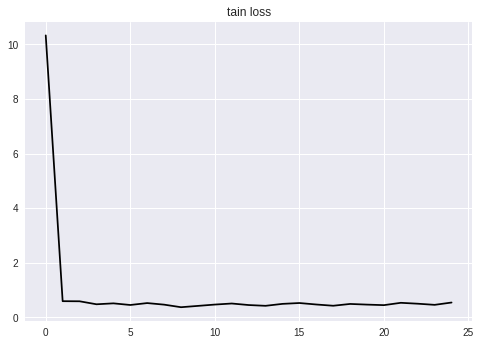

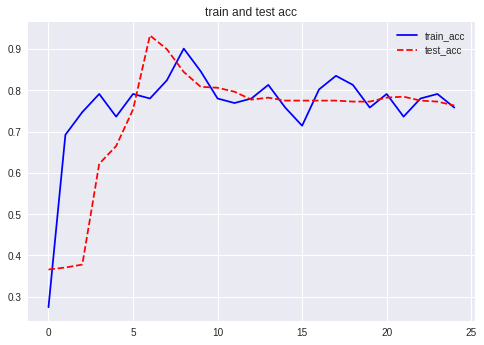

In [52]:
plt.plot(loss_train, 'k-')
plt.title("tain loss")
plt.show()

plt.plot(train_acc, 'b-', label="train_acc")
plt.plot(test_acc, 'r--', label='test_acc')
plt.title("train and test acc")
plt.legend()
plt.show()
        